<a href="https://colab.research.google.com/github/SzymonLabedziewski/Metody-Inteligencji-Obliczeniowej/blob/main/lab03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/Colab Notebooks/MIO"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
lab02_fuel.txt	lab02.ipynb  lab03.ipynb  lab03_medicine.txt  lab03_yeast.data	lab03_yeast.names


#1.1

**Proszę pobrać plik medicine.txt, zawierający wyniki analizy nowego leku. W dwóch pierwszych kolumnach znajduje się stężenie dwóch składników w próbce krwi, w trzeciej - informacja o tym, czy lek zadziałał.**

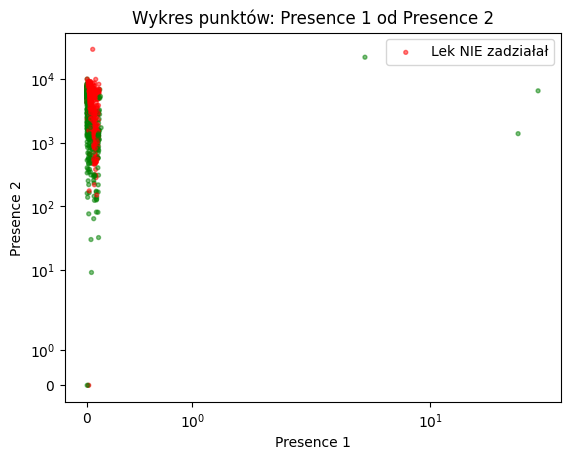

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Wczytanie danych z pliku medicine.txt
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/MIO/lab03_medicine.txt")

# print(data)
x = data.iloc[:, 0]
y = data.iloc[:, 1]
z = data['Was medicine effective?']

os_x = data.columns[0]
os_y = data.columns[1]

colors = {1: 'g', 0:'r'}

plt.scatter(x, y, c=z.map(colors), alpha =0.5, s=8, label='Lek NIE zadziałał')
plt.xlabel(os_x)
plt.xscale("symlog")
plt.ylabel(os_y)
plt.yscale("symlog")
plt.title(f"Wykres punktów: {os_x} od {os_y}")
plt.legend()
plt.show()

> Wykres przedstawia zależność między dwoma składnikami w próbce krwi (Presence 1 i Presence 2). Użyto skali sym-log, co pozwala zobaczyć wartości bliskie zeru oraz bardzo duże liczby.
>
> Dane są rozproszone oraz trudno zauważyć zależność między wartościami stężeń a skutecznością leku.
> Widoczne są wartości odstające (outliery), które utrudniają analizę.



---



# 1.2
**Dane nie są znormalizowane. Proszę znormalizować dane.**

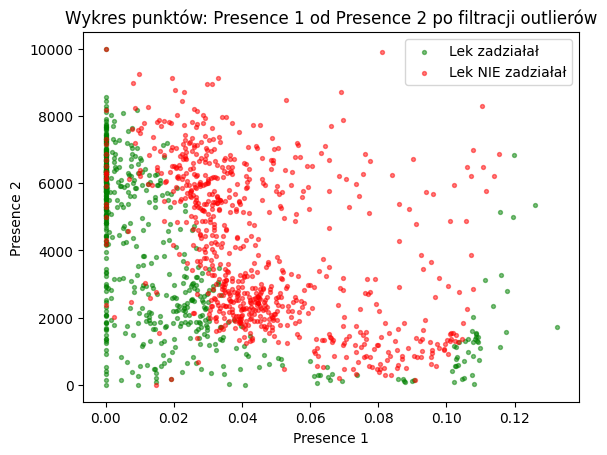

In [ ]:
import numpy as np
# Liczymy średnią i odchylenie standardowe dla X i Y
mean_x, std_x = np.mean(x), np.std(x)
mean_y, std_y = np.mean(y), np.std(y)

# Zastosowanie zasady 3 sigm (odrzucamy outliery)
mask_x = (x >= mean_x - 3*std_x) & (x <= mean_x + 3*std_x)
mask_y = (y >= mean_y - 3*std_y) & (y <= mean_y + 3*std_y)
# Usuwamy punkty, które są outlierami na osi X lub Y
mask = mask_x & mask_y

x_filtred = x[mask]
y_filterd = y[mask]
status_filterd = z[mask]

for s, color, label in [(1, 'green', 'Lek zadziałał'), (0, 'red', 'Lek NIE zadziałał')]:
    plt.scatter(
        x_filtred[status_filterd == s],
        y_filterd[status_filterd == s],
        c=color, alpha = 0.5, s=8, label=label
      )

plt.xlabel(os_x)
# plt.xscale("symlog")
plt.ylabel(os_y)
# plt.yscale("symlog")
plt.title(f"Wykres punktów: {os_x} od {os_y} po filtracji outlierów")
plt.legend()
plt.show()

> Dane zostały przefiltrowane zgodnie z zasadą 3 sigm, co oznacza usunięcie wartości skrajnych. Po tej operacji wykres jest bardziej czytelny – dane są lepiej rozłożone, a zależności stają się bardziej widoczne.
>
> Widać, że czerwone punkty (lek nieskuteczny) są bardziej skoncentrowane przy wyższych wartościach Presence 2.
Można dostrzec pewną zależność – pacjenci, u których lek zadziałał (zielone punkty), mają inne rozkłady składników we krwi niż ci, u których lek nie był skuteczny.


---




#1.3
**Podzielić je na zbiór uczący i testujący w proporcjach 80-20 (należy pamiętać o proporcjach klas), zaproponować wielowarstwową sieć neuronową i zbadać jej skuteczność dla różnych ilości warstw i neuronów w tych warstwach.**

Dokładnośc na zbiorze treningowym:  0.934944
Dokładnośc na zbiorze testowym:  0.896296
Skuteczność dla różnych konfiguracji sieci neuronowej:
Konfiguracja (10,): 0.8778
Konfiguracja (50,): 0.8926
Konfiguracja (100,): 0.8815
Konfiguracja (50, 50): 0.8926
Konfiguracja (100, 50): 0.8926
Konfiguracja (100, 100): 0.8889


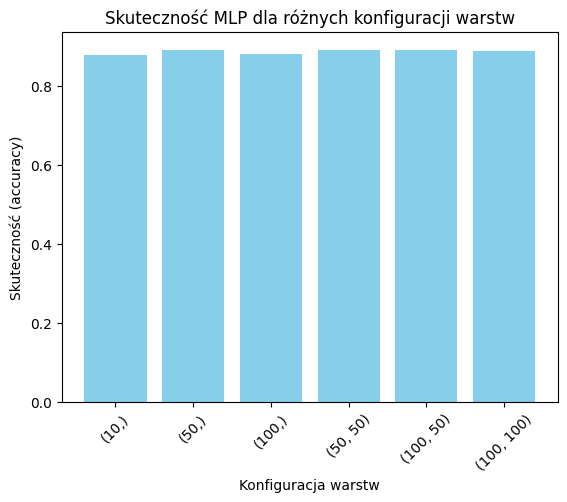

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

data_xy = np.column_stack((x_filtred,y_filterd))

x_train, x_test, y_train, y_test = train_test_split(
    np.column_stack((x_filtred, y_filterd)),
    status_filterd,
    test_size=0.2,
    random_state=42,
    stratify=status_filterd
    )

# Standaryzacja danych
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Tworzenie bardziej rozbudowanego modelu MLP
model_MLP = MLPClassifier(hidden_layer_sizes = (300,300,300), activation='relu', solver='adam', max_iter=2000, alpha=0.0001)

# Trenowanie modelu
model_MLP.fit(x_train, y_train)
y_pred = model_MLP.predict(x_test)

# Ocena modelu
train_accuracy = accuracy_score(y_train, model_MLP.predict(x_train))
test_accuracy = accuracy_score(y_test, model_MLP.predict(x_test))

print(f"Dokładnośc na zbiorze treningowym: {train_accuracy: 4f}")
print(f"Dokładnośc na zbiorze testowym:    {test_accuracy: 4f}")


#=============================================#

# Funkcja do trenowania modelu MLP i oceny skuteczności
def train_and_evaluate(mlp, X_train, X_test, y_train, y_test):
    # Trenowanie modelu
    mlp.fit(X_train, y_train)

    # Predykcja na zbiorze testowym
    y_pred = mlp.predict(X_test)

    # Ocena skuteczności
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

#=============================================#

# Różne konfiguracje sieci neuronowych
hidden_layer_configs = [(10,), (50,), (100,), (50,50), (100,50), (100,100)]

# Przechowywanie wyników
results = {}

for config in hidden_layer_configs:
  # Tworzenie modelu MLp z odpowiednią konfiguracją warstw
  mlp = MLPClassifier(hidden_layer_sizes = (300,300,300), activation='relu', solver='adam', max_iter=1000, alpha=0.0001)

  # Ocena modelu
  accuracy = train_and_evaluate(mlp, x_train, x_test, y_train, y_test)

  # Zapisanie wyników
  results[config] = accuracy



# Wyświetlenie wyników
print("Skuteczność dla różnych konfiguracji sieci neuronowej:")
for config, accuracy in results.items():
    print(f"Konfiguracja {config}: {accuracy:.4f}")

# Wizualizacja wyników
configs = [str(config) for config in hidden_layer_configs]
accuracies = list(results.values())

plt.bar(configs, accuracies, color='skyblue')
plt.xlabel("Konfiguracja warstw")
plt.ylabel("Skuteczność (accuracy)")
plt.title("Skuteczność MLP dla różnych konfiguracji warstw")
plt.xticks(rotation=45)
plt.show()

1. Podział danych

>Dane zostały podzielone na zbiór treningowy (80%) i testowy (20%) z zachowaniem proporcji klas.
Przeprowadzono standaryzację, co poprawia stabilność i skuteczność uczenia sieci neuronowej.

2. Uczenie sieci neuronowej

>Pierwszy model z trzema warstwami (po 300 neuronów każda) osiągnął 93,49% skuteczności na zbiorze treningowym i 89,63% na zbiorze testowym.
Wysoka dokładność oznacza, że model dobrze uczy się zależności w danych.

3. Eksperymenty z różnymi konfiguracjami sieci

>Przetestowano różne warianty liczby warstw i neuronów:
>
>- Najwyższa skuteczność (89,26%) została uzyskana dla układów (50,), (50,50) oraz (100,50).
>
>- Najniższa skuteczność (87,78%) była dla konfiguracji (10,).
>
>- Sieć (100,100) miała skuteczność 88,89%, co sugeruje, że dodanie większej liczby neuronów nie zawsze poprawia wynik.


---



#1.4
**Proszę narysować w jaki sposób sieć dokonała podziału w zbiorze dla kilku sieci (zarówno tych z dobrymi, jak i złymi wynikami) oraz jak wygląda poprawny podział zbioru.**

**Proszę również przedstawić wyniki dla 5-8 różnych struktur sieci, wraz z oceną, która z nich najlepiej poradziła sobie z zadaniem klasyfikacji.**

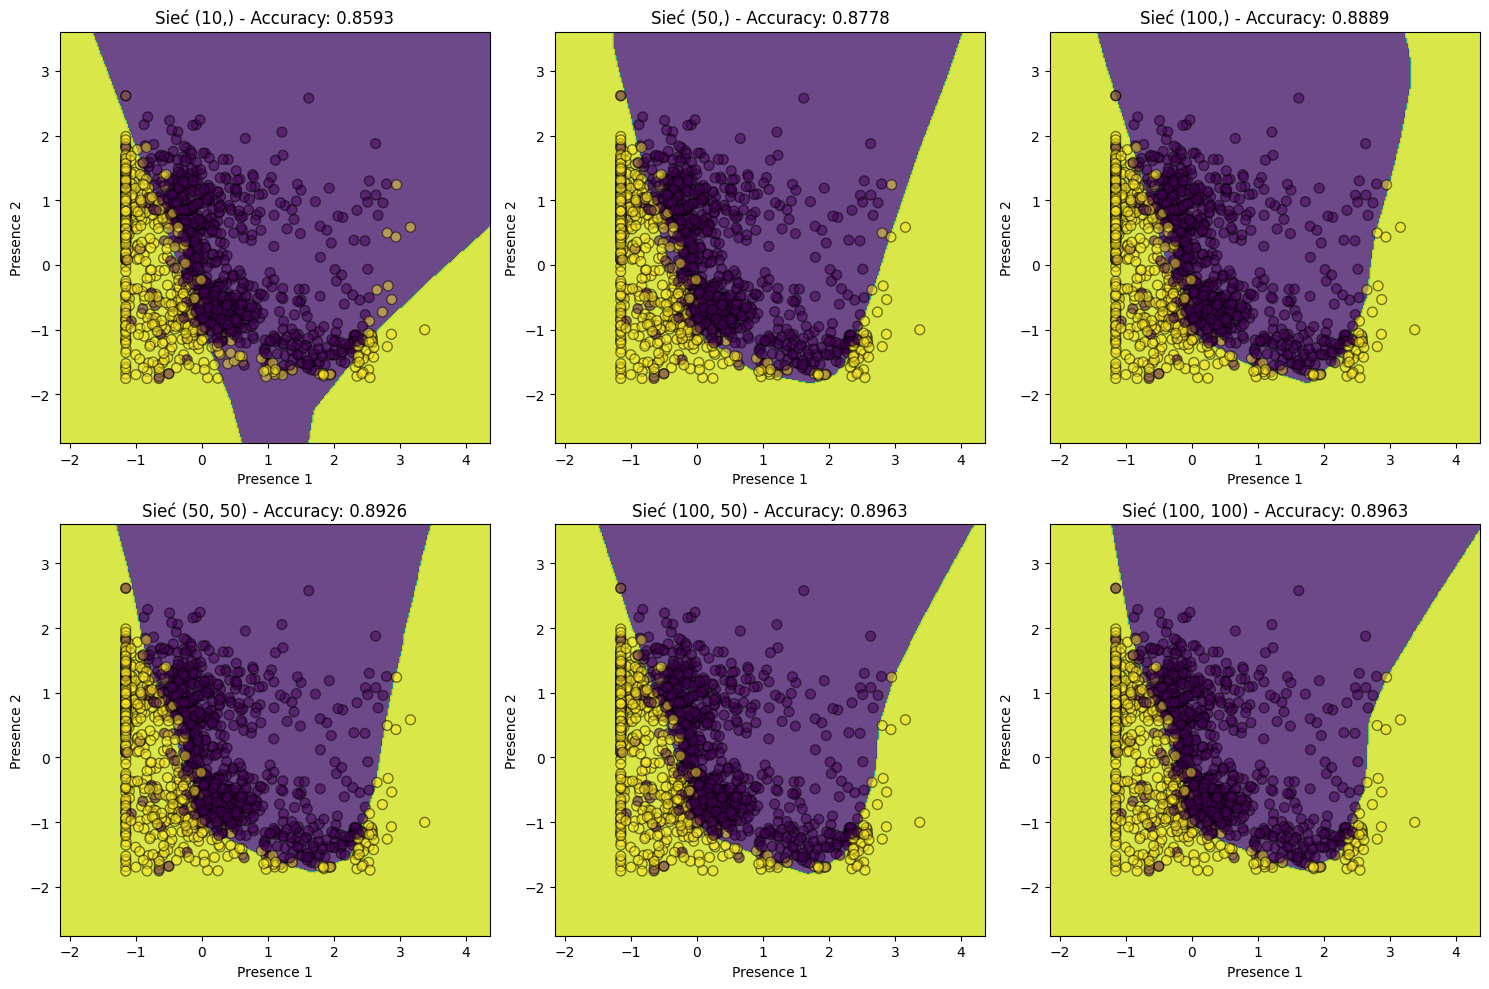

Skuteczność dla różnych konfiguracji sieci neuronowej:
Konfiguracja (10,): 0.8593
Konfiguracja (50,): 0.8778
Konfiguracja (100,): 0.8889
Konfiguracja (50, 50): 0.8926
Konfiguracja (100, 50): 0.8963
Konfiguracja (100, 100): 0.8963


In [ ]:
# Wizualizacja decyzji modelu
def plot_decision_boundary(X, y, model, ax):
    h = .02  # Rozmiar kroku siatki
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Rysowanie granicy decyzji
    ax.contourf(xx, yy, Z, alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50, alpha=0.5)
    ax.set_title("Granica decyzji")
    ax.set_xlabel(os_x)
    ax.set_ylabel(os_y)

# Przygotowanie danych
data_xy = np.column_stack((x_filtred, y_filterd))

x_train, x_test, y_train, y_test = train_test_split(
    np.column_stack((x_filtred, y_filterd)),
    status_filterd,
    test_size=0.2,
    random_state=42,
    stratify=status_filterd
)

# Standaryzacja danych
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Różne konfiguracje sieci neuronowych
hidden_layer_configs = [(10,), (50,), (100,), (50,50), (100,50), (100,100)]

# Rysowanie wyników
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Przechowywanie wyników
results = {}

for idx, config in enumerate(hidden_layer_configs):
    # Tworzenie modelu MLP z odpowiednią konfiguracją warstw
    mlp = MLPClassifier(hidden_layer_sizes=config, activation='relu', solver='adam', max_iter=1000, alpha=0.0001)

    # Trenowanie modelu
    mlp.fit(x_train, y_train)

    # Ocena modelu
    accuracy = accuracy_score(y_test, mlp.predict(x_test))
    results[config] = accuracy

    # Rysowanie granicy decyzji dla modelu
    plot_decision_boundary(np.vstack((x_train, x_test)), np.hstack((y_train, y_test)), mlp, axes[idx])
    axes[idx].set_title(f"Sieć {config} - Accuracy: {accuracy:.4f}")

# Wizualizacja wyników
plt.tight_layout()
plt.show()

# Wyświetlenie wyników
print("Skuteczność dla różnych konfiguracji sieci neuronowej:")
for config, accuracy in results.items():
    print(f"Konfiguracja {config}: {accuracy:.4f}")


1. Podział przestrzeni decyzyjnej

>Wizualizacje pokazują, jak różne konfiguracje sieci neuronowej dokonały klasyfikacji danych.
Proste modele (np. (10,)) mają mniej dokładne i bardziej nieregularne granice decyzyjne.
Bardziej złożone sieci (np. (100,50) czy (100,100)) lepiej dopasowują się do danych, tworząc bardziej precyzyjne podziały.

2. Skuteczność różnych konfiguracji

>Najlepsze wyniki osiągnęły sieci (100,50) i (100,100) z dokładnością 89,63%.
Sieć (50,50) osiągnęła 89,26%, co sugeruje, że dodanie drugiej warstwy poprawia dokładność.
Sieć (10,) miała najgorszy wynik – 85,93%, co wskazuje, że pojedyncza warstwa z małą liczbą neuronów nie jest wystarczająco skuteczna.


---



> *Dane zawierały wiele wartości odstających, które utrudniały analizę. Po ich usunięciu wykres lepiej ukazał potencjalne zależności między stężeniami składników a skutecznością leku. Możliwe, że Presence 2 ma większy wpływ na skuteczność leku niż Presence 1.*

> *Sieć o dużej liczbie neuronów (300,300,300) działa bardzo dobrze, ale nieznacznie przewyższa prostsze konfiguracje. Sieci o średniej wielkości (50,50) czy (100,50) również osiągają wysoką skuteczność, co oznacza, że bardziej złożona sieć nie zawsze jest konieczna. Sieci o dwóch warstwach ukrytych z większą liczbą neuronów (np. (100,50), (100,100)) uzyskały najlepsze wyniki. Bardziej złożone modele lepiej dopasowują się do danych, ale różnice w skuteczności między (50,50) a (100,100) są niewielkie. Najprostsza sieć (10,) miała najgorszy podział, co potwierdza, że minimalna liczba neuronów nie jest wystarczająca do skutecznej klasyfikacji.*


---



---



#2
**Proszę pobrać zbiór ręcznie pisanych cyfr z https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits (można to zrobić funkcją datasets.load_digits() w sklearnie).**

**Proszę sprawdzić skuteczność klasyfikacji na tym zbiorze za pomocą wielowarstwowej sieci neuronowej.**

Skuteczność sieci neuronowej: 0.9778


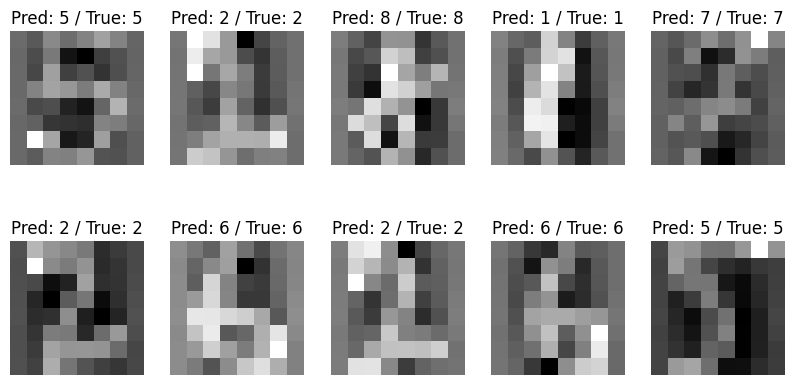

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Wczytanie zbioru danych
digits = load_digits()
X, y = digits.data, digits.target

# Podział na zbiór uczący i testowy (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standaryzacja danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

# Predykcja i ocena modelu
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Skuteczność sieci neuronowej: {accuracy:.4f}')

# Wizualizacja wyników
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X_test[i].reshape(8, 8), cmap='gray')
    ax.set_title(f'Pred: {y_pred[i]} / True: {y_test[i]}')
    ax.axis('off')
plt.show()


> Wykorzystano zbiór Optical Recognition of Handwritten Digits zawierający cyfry zapisane ręcznie.
> Dane zostały podzielone na zbiór uczący (80%) i testowy (20%). Przed trenowaniem zastosowano standaryzację danych, co pozwala na lepszą stabilność i szybkość uczenia modelu.
>
>Zastosowana sieć neuronowa z dwiema warstwami ukrytymi (100, 50) uzyskała wysoką skuteczność: 97,78%.
>Wizualizacja wyników ukazuje, że wszystkie przewidywania były zgodne z rzeczywistością, co potwierdza wysoką jakość modelu.


---



---



#3.1
**Proszę sprawdzić, jak zmieni się poprawność klasyfikacji na zbiorze ręcznie pisanych cyfr dla różnych architektur sieci, funkcji aktywacji, ilości epok uczenia i algorytmów uczenia.**

Konfiguracja (50,), aktywacja relu, solver adam, epoki 500 → Accuracy: 0.9722
Konfiguracja (50,), aktywacja relu, solver adam, epoki 1000 → Accuracy: 0.9722
Konfiguracja (50,), aktywacja relu, solver adam, epoki 2000 → Accuracy: 0.9722


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (50,), aktywacja relu, solver sgd, epoki 500 → Accuracy: 0.9639
Konfiguracja (50,), aktywacja relu, solver sgd, epoki 1000 → Accuracy: 0.9667
Konfiguracja (50,), aktywacja relu, solver sgd, epoki 2000 → Accuracy: 0.9667
Konfiguracja (50,), aktywacja relu, solver lbfgs, epoki 500 → Accuracy: 0.9694
Konfiguracja (50,), aktywacja relu, solver lbfgs, epoki 1000 → Accuracy: 0.9694
Konfiguracja (50,), aktywacja relu, solver lbfgs, epoki 2000 → Accuracy: 0.9694
Konfiguracja (50,), aktywacja tanh, solver adam, epoki 500 → Accuracy: 0.9778
Konfiguracja (50,), aktywacja tanh, solver adam, epoki 1000 → Accuracy: 0.9778
Konfiguracja (50,), aktywacja tanh, solver adam, epoki 2000 → Accuracy: 0.9778


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (50,), aktywacja tanh, solver sgd, epoki 500 → Accuracy: 0.9528
Konfiguracja (50,), aktywacja tanh, solver sgd, epoki 1000 → Accuracy: 0.9583
Konfiguracja (50,), aktywacja tanh, solver sgd, epoki 2000 → Accuracy: 0.9583
Konfiguracja (50,), aktywacja tanh, solver lbfgs, epoki 500 → Accuracy: 0.9722
Konfiguracja (50,), aktywacja tanh, solver lbfgs, epoki 1000 → Accuracy: 0.9722
Konfiguracja (50,), aktywacja tanh, solver lbfgs, epoki 2000 → Accuracy: 0.9722
Konfiguracja (50,), aktywacja logistic, solver adam, epoki 500 → Accuracy: 0.9806
Konfiguracja (50,), aktywacja logistic, solver adam, epoki 1000 → Accuracy: 0.9806
Konfiguracja (50,), aktywacja logistic, solver adam, epoki 2000 → Accuracy: 0.9806


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (50,), aktywacja logistic, solver sgd, epoki 500 → Accuracy: 0.9139


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (50,), aktywacja logistic, solver sgd, epoki 1000 → Accuracy: 0.9361
Konfiguracja (50,), aktywacja logistic, solver sgd, epoki 2000 → Accuracy: 0.9472
Konfiguracja (50,), aktywacja logistic, solver lbfgs, epoki 500 → Accuracy: 0.9556
Konfiguracja (50,), aktywacja logistic, solver lbfgs, epoki 1000 → Accuracy: 0.9556
Konfiguracja (50,), aktywacja logistic, solver lbfgs, epoki 2000 → Accuracy: 0.9556
Konfiguracja (100,), aktywacja relu, solver adam, epoki 500 → Accuracy: 0.9750
Konfiguracja (100,), aktywacja relu, solver adam, epoki 1000 → Accuracy: 0.9750
Konfiguracja (100,), aktywacja relu, solver adam, epoki 2000 → Accuracy: 0.9750


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (100,), aktywacja relu, solver sgd, epoki 500 → Accuracy: 0.9722
Konfiguracja (100,), aktywacja relu, solver sgd, epoki 1000 → Accuracy: 0.9722
Konfiguracja (100,), aktywacja relu, solver sgd, epoki 2000 → Accuracy: 0.9722
Konfiguracja (100,), aktywacja relu, solver lbfgs, epoki 500 → Accuracy: 0.9639
Konfiguracja (100,), aktywacja relu, solver lbfgs, epoki 1000 → Accuracy: 0.9639
Konfiguracja (100,), aktywacja relu, solver lbfgs, epoki 2000 → Accuracy: 0.9639
Konfiguracja (100,), aktywacja tanh, solver adam, epoki 500 → Accuracy: 0.9778
Konfiguracja (100,), aktywacja tanh, solver adam, epoki 1000 → Accuracy: 0.9778
Konfiguracja (100,), aktywacja tanh, solver adam, epoki 2000 → Accuracy: 0.9778


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (100,), aktywacja tanh, solver sgd, epoki 500 → Accuracy: 0.9667
Konfiguracja (100,), aktywacja tanh, solver sgd, epoki 1000 → Accuracy: 0.9667
Konfiguracja (100,), aktywacja tanh, solver sgd, epoki 2000 → Accuracy: 0.9667
Konfiguracja (100,), aktywacja tanh, solver lbfgs, epoki 500 → Accuracy: 0.9694
Konfiguracja (100,), aktywacja tanh, solver lbfgs, epoki 1000 → Accuracy: 0.9694
Konfiguracja (100,), aktywacja tanh, solver lbfgs, epoki 2000 → Accuracy: 0.9694
Konfiguracja (100,), aktywacja logistic, solver adam, epoki 500 → Accuracy: 0.9778
Konfiguracja (100,), aktywacja logistic, solver adam, epoki 1000 → Accuracy: 0.9778
Konfiguracja (100,), aktywacja logistic, solver adam, epoki 2000 → Accuracy: 0.9778


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (100,), aktywacja logistic, solver sgd, epoki 500 → Accuracy: 0.9333


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (100,), aktywacja logistic, solver sgd, epoki 1000 → Accuracy: 0.9556
Konfiguracja (100,), aktywacja logistic, solver sgd, epoki 2000 → Accuracy: 0.9556
Konfiguracja (100,), aktywacja logistic, solver lbfgs, epoki 500 → Accuracy: 0.9556
Konfiguracja (100,), aktywacja logistic, solver lbfgs, epoki 1000 → Accuracy: 0.9556
Konfiguracja (100,), aktywacja logistic, solver lbfgs, epoki 2000 → Accuracy: 0.9556
Konfiguracja (50, 50), aktywacja relu, solver adam, epoki 500 → Accuracy: 0.9722
Konfiguracja (50, 50), aktywacja relu, solver adam, epoki 1000 → Accuracy: 0.9722
Konfiguracja (50, 50), aktywacja relu, solver adam, epoki 2000 → Accuracy: 0.9722


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (50, 50), aktywacja relu, solver sgd, epoki 500 → Accuracy: 0.9694
Konfiguracja (50, 50), aktywacja relu, solver sgd, epoki 1000 → Accuracy: 0.9694
Konfiguracja (50, 50), aktywacja relu, solver sgd, epoki 2000 → Accuracy: 0.9694
Konfiguracja (50, 50), aktywacja relu, solver lbfgs, epoki 500 → Accuracy: 0.9667
Konfiguracja (50, 50), aktywacja relu, solver lbfgs, epoki 1000 → Accuracy: 0.9667
Konfiguracja (50, 50), aktywacja relu, solver lbfgs, epoki 2000 → Accuracy: 0.9667
Konfiguracja (50, 50), aktywacja tanh, solver adam, epoki 500 → Accuracy: 0.9778
Konfiguracja (50, 50), aktywacja tanh, solver adam, epoki 1000 → Accuracy: 0.9778
Konfiguracja (50, 50), aktywacja tanh, solver adam, epoki 2000 → Accuracy: 0.9778


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (50, 50), aktywacja tanh, solver sgd, epoki 500 → Accuracy: 0.9694
Konfiguracja (50, 50), aktywacja tanh, solver sgd, epoki 1000 → Accuracy: 0.9694
Konfiguracja (50, 50), aktywacja tanh, solver sgd, epoki 2000 → Accuracy: 0.9694
Konfiguracja (50, 50), aktywacja tanh, solver lbfgs, epoki 500 → Accuracy: 0.9694
Konfiguracja (50, 50), aktywacja tanh, solver lbfgs, epoki 1000 → Accuracy: 0.9694
Konfiguracja (50, 50), aktywacja tanh, solver lbfgs, epoki 2000 → Accuracy: 0.9694
Konfiguracja (50, 50), aktywacja logistic, solver adam, epoki 500 → Accuracy: 0.9778
Konfiguracja (50, 50), aktywacja logistic, solver adam, epoki 1000 → Accuracy: 0.9778
Konfiguracja (50, 50), aktywacja logistic, solver adam, epoki 2000 → Accuracy: 0.9778


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (50, 50), aktywacja logistic, solver sgd, epoki 500 → Accuracy: 0.6917


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (50, 50), aktywacja logistic, solver sgd, epoki 1000 → Accuracy: 0.8306


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (50, 50), aktywacja logistic, solver sgd, epoki 2000 → Accuracy: 0.9250
Konfiguracja (50, 50), aktywacja logistic, solver lbfgs, epoki 500 → Accuracy: 0.9611
Konfiguracja (50, 50), aktywacja logistic, solver lbfgs, epoki 1000 → Accuracy: 0.9611
Konfiguracja (50, 50), aktywacja logistic, solver lbfgs, epoki 2000 → Accuracy: 0.9611
Konfiguracja (100, 50), aktywacja relu, solver adam, epoki 500 → Accuracy: 0.9778
Konfiguracja (100, 50), aktywacja relu, solver adam, epoki 1000 → Accuracy: 0.9778
Konfiguracja (100, 50), aktywacja relu, solver adam, epoki 2000 → Accuracy: 0.9778
Konfiguracja (100, 50), aktywacja relu, solver sgd, epoki 500 → Accuracy: 0.9750
Konfiguracja (100, 50), aktywacja relu, solver sgd, epoki 1000 → Accuracy: 0.9750
Konfiguracja (100, 50), aktywacja relu, solver sgd, epoki 2000 → Accuracy: 0.9750
Konfiguracja (100, 50), aktywacja relu, solver lbfgs, epoki 500 → Accuracy: 0.9694
Konfiguracja (100, 50), aktywacja relu, solver lbfgs, epoki 1000 → Accuracy: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (100, 50), aktywacja tanh, solver sgd, epoki 500 → Accuracy: 0.9667
Konfiguracja (100, 50), aktywacja tanh, solver sgd, epoki 1000 → Accuracy: 0.9694
Konfiguracja (100, 50), aktywacja tanh, solver sgd, epoki 2000 → Accuracy: 0.9694
Konfiguracja (100, 50), aktywacja tanh, solver lbfgs, epoki 500 → Accuracy: 0.9694
Konfiguracja (100, 50), aktywacja tanh, solver lbfgs, epoki 1000 → Accuracy: 0.9694
Konfiguracja (100, 50), aktywacja tanh, solver lbfgs, epoki 2000 → Accuracy: 0.9694
Konfiguracja (100, 50), aktywacja logistic, solver adam, epoki 500 → Accuracy: 0.9639
Konfiguracja (100, 50), aktywacja logistic, solver adam, epoki 1000 → Accuracy: 0.9639
Konfiguracja (100, 50), aktywacja logistic, solver adam, epoki 2000 → Accuracy: 0.9639


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (100, 50), aktywacja logistic, solver sgd, epoki 500 → Accuracy: 0.7222


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (100, 50), aktywacja logistic, solver sgd, epoki 1000 → Accuracy: 0.8556


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (100, 50), aktywacja logistic, solver sgd, epoki 2000 → Accuracy: 0.9250
Konfiguracja (100, 50), aktywacja logistic, solver lbfgs, epoki 500 → Accuracy: 0.9583
Konfiguracja (100, 50), aktywacja logistic, solver lbfgs, epoki 1000 → Accuracy: 0.9583
Konfiguracja (100, 50), aktywacja logistic, solver lbfgs, epoki 2000 → Accuracy: 0.9583
Konfiguracja (100, 100), aktywacja relu, solver adam, epoki 500 → Accuracy: 0.9778
Konfiguracja (100, 100), aktywacja relu, solver adam, epoki 1000 → Accuracy: 0.9778
Konfiguracja (100, 100), aktywacja relu, solver adam, epoki 2000 → Accuracy: 0.9778
Konfiguracja (100, 100), aktywacja relu, solver sgd, epoki 500 → Accuracy: 0.9722
Konfiguracja (100, 100), aktywacja relu, solver sgd, epoki 1000 → Accuracy: 0.9722
Konfiguracja (100, 100), aktywacja relu, solver sgd, epoki 2000 → Accuracy: 0.9722
Konfiguracja (100, 100), aktywacja relu, solver lbfgs, epoki 500 → Accuracy: 0.9722
Konfiguracja (100, 100), aktywacja relu, solver lbfgs, epoki 1000 → 

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (100, 100), aktywacja tanh, solver sgd, epoki 500 → Accuracy: 0.9778
Konfiguracja (100, 100), aktywacja tanh, solver sgd, epoki 1000 → Accuracy: 0.9750
Konfiguracja (100, 100), aktywacja tanh, solver sgd, epoki 2000 → Accuracy: 0.9750
Konfiguracja (100, 100), aktywacja tanh, solver lbfgs, epoki 500 → Accuracy: 0.9694
Konfiguracja (100, 100), aktywacja tanh, solver lbfgs, epoki 1000 → Accuracy: 0.9694
Konfiguracja (100, 100), aktywacja tanh, solver lbfgs, epoki 2000 → Accuracy: 0.9694
Konfiguracja (100, 100), aktywacja logistic, solver adam, epoki 500 → Accuracy: 0.9694
Konfiguracja (100, 100), aktywacja logistic, solver adam, epoki 1000 → Accuracy: 0.9694
Konfiguracja (100, 100), aktywacja logistic, solver adam, epoki 2000 → Accuracy: 0.9694


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (100, 100), aktywacja logistic, solver sgd, epoki 500 → Accuracy: 0.7056


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (100, 100), aktywacja logistic, solver sgd, epoki 1000 → Accuracy: 0.8556


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Konfiguracja (100, 100), aktywacja logistic, solver sgd, epoki 2000 → Accuracy: 0.9361
Konfiguracja (100, 100), aktywacja logistic, solver lbfgs, epoki 500 → Accuracy: 0.9667
Konfiguracja (100, 100), aktywacja logistic, solver lbfgs, epoki 1000 → Accuracy: 0.9667
Konfiguracja (100, 100), aktywacja logistic, solver lbfgs, epoki 2000 → Accuracy: 0.9667

TOP 10 najlepszych konfiguracji:
    Hidden Layers Activation Solver  Epochs  Accuracy
18          (50,)   logistic   adam     500  0.980556
20          (50,)   logistic   adam    2000  0.980556
19          (50,)   logistic   adam    1000  0.980556
10          (50,)       tanh   adam    1000  0.977778
36         (100,)       tanh   adam     500  0.977778
9           (50,)       tanh   adam     500  0.977778
11          (50,)       tanh   adam    2000  0.977778
109    (100, 100)       relu   adam    1000  0.977778
110    (100, 100)       relu   adam    2000  0.977778
83      (100, 50)       relu   adam    2000  0.977778


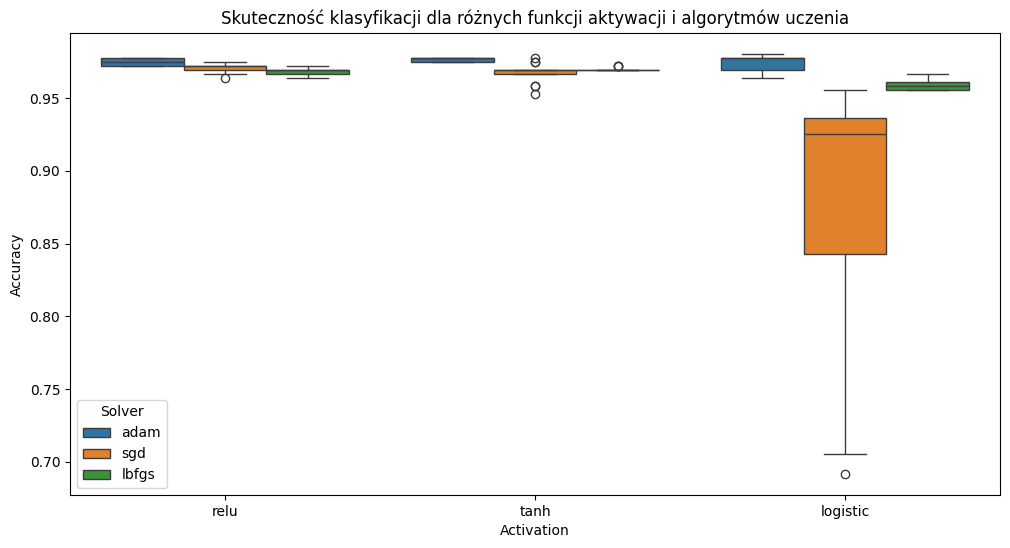

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


digits = load_digits()
X, y = digits.data, digits.target

# Podział zbioru na treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standaryzacja danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Możliwe konfiguracje do przetestowania
hidden_layer_configs = [(50,), (100,), (50,50), (100,50), (100,100)]
activation_functions = ['relu', 'tanh', 'logistic']
solvers = ['adam', 'sgd', 'lbfgs']
epochs = [500, 1000, 2000]

# Przechowywanie wyników
results = []


# Testowanie różnych kombinacji parametrów
for config in hidden_layer_configs:
    for activation in activation_functions:
        for solver in solvers:
            for epoch in epochs:
                # Tworzenie / trenowanie modelu
                mlp = MLPClassifier(
                    hidden_layer_sizes=config,
                    activation=activation,
                    solver=solver,
                    max_iter=epoch,
                    random_state=42
                )
                mlp.fit(X_train, y_train)
                acc = accuracy_score(y_test, mlp.predict(X_test))

                # Zapis wyników
                results.append((config, activation, solver, epoch, acc))
                print(f"Konfiguracja {config}, aktywacja {activation}, solver {solver}, epoki {epoch} → Accuracy: {acc:.4f}")


# ------------------------------
import pandas as pd

df_results = pd.DataFrame(results, columns=['Hidden Layers', 'Activation', 'Solver', 'Epochs', 'Accuracy'])
df_sorted = df_results.sort_values(by='Accuracy', ascending=False)


# print("\nTOP 10 najlepszych konfiguracji:")
# print(df_sorted.head(10))

# Wykres skuteczności dla różnych konfiguracji
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(x='Activation', y='Accuracy', hue='Solver', data=df_results)
plt.title("Skuteczność klasyfikacji dla różnych funkcji aktywacji i algorytmów uczenia")
plt.show()


> Wykorzystano model MLPClassifier ze zbioru sklearn, a testowane parametry obejmowały:
>
>- Różne liczby neuronów w warstwach ukrytych { (50,), (100,), (50,50), (100,50), (100,100) }
>
>- Funkcje aktywacji: ReLU, tanh, logistic
>
>- Algorytmy optymalizacji: Adam, SGD, LBFGS
>
>- Liczba epok: 500, 1000, 2000

>Najwyższa skuteczność (accuracy = 0.9806) została osiągnięta dla konfiguracji:
>>jedna warstwa ukryta (50 neuronów), funkcja aktywacji logistic, solver Adam, niezależnie od liczby epok.
>
> Funkcja aktywacji logistic dawała lepsze wyniki w połączeniu z solverem Adam.
>
> Solver Adam zapewniał najlepsze rezultaty, natomiast solver SGD był mniej stabilny i wymagał większej liczby epok do osiągnięcia dobrej złożoności.
>
>Sieci wielowarstwowe (np. (50,50) czy (100,50)) nie zawsze poprawiały skuteczność, co sugeruje, że nadmierna złożoność modelu niekoniecznie przekłada się na lepsze wyniki.
>
>W przypadku solvera SGD zauważono, że zbieżność była mniejsza, szczególnie dla funkcji aktywacji logistic (niska skuteczność dla małej liczby epok; stopniowa poprawa wraz ze wzrostem iteracji).
>
>Solver LBFGS również dawał dobre wyniki, jednak był porównywalnie słabszy pod względem stabilności względem solvera Adam.


---



#3.2
**Proszę zbadać wpływ współczynnika uczenia (learning_rate) podczas używania algorytmu SGD. Dla najciekawszych przykładów proszę wypisać macierze pomyłek oraz wyliczyć wszystkie poznane metryki.**

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Learning Rate: 0.0001 → Accuracy: 0.9500
Learning Rate: 0.0010 → Accuracy: 0.9722
Learning Rate: 0.0100 → Accuracy: 0.9722
Learning Rate: 0.1000 → Accuracy: 0.9750
Learning Rate: 0.5000 → Accuracy: 0.8750
Learning Rate: 1.0000 → Accuracy: 0.1028


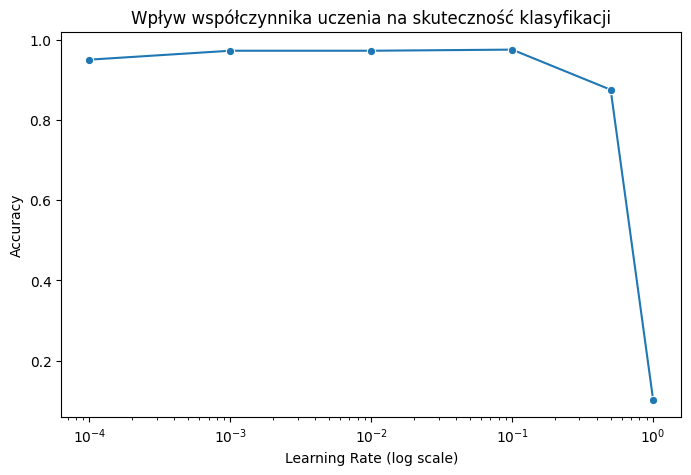


== Wyniki dla Learning Rate = 0.1000 ==
Accuracy: 0.9750
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        36
           1       0.92      0.94      0.93        36
           2       0.97      1.00      0.99        35
           3       1.00      1.00      1.00        37
           4       0.97      1.00      0.99        36
           5       1.00      0.97      0.99        37
           6       0.97      0.97      0.97        36
           7       0.97      1.00      0.99        36
           8       1.00      0.86      0.92        35
           9       0.97      1.00      0.99        36

    accuracy                           0.97       360
   macro avg       0.98      0.97      0.97       360
weighted avg       0.98      0.97      0.97       360



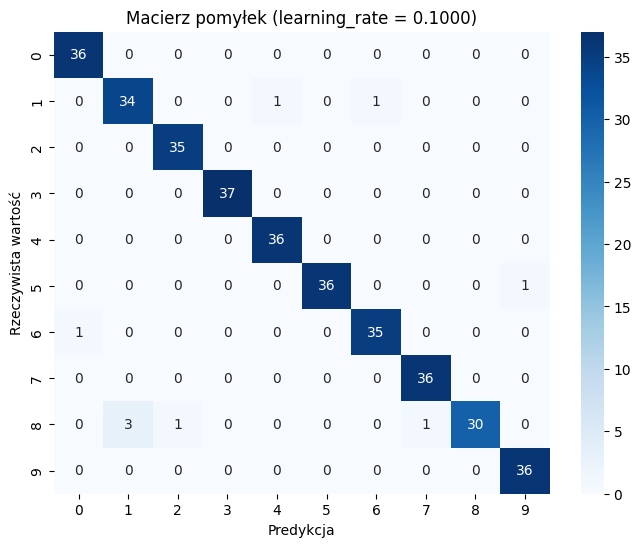


== Wyniki dla Learning Rate = 1.0000 ==
Accuracy: 0.1028
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.00      0.00      0.00        36
           2       0.00      0.00      0.00        35
           3       0.10      1.00      0.19        37
           4       0.00      0.00      0.00        36
           5       0.00      0.00      0.00        37
           6       0.00      0.00      0.00        36
           7       0.00      0.00      0.00        36
           8       0.00      0.00      0.00        35
           9       0.00      0.00      0.00        36

    accuracy                           0.10       360
   macro avg       0.01      0.10      0.02       360
weighted avg       0.01      0.10      0.02       360



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


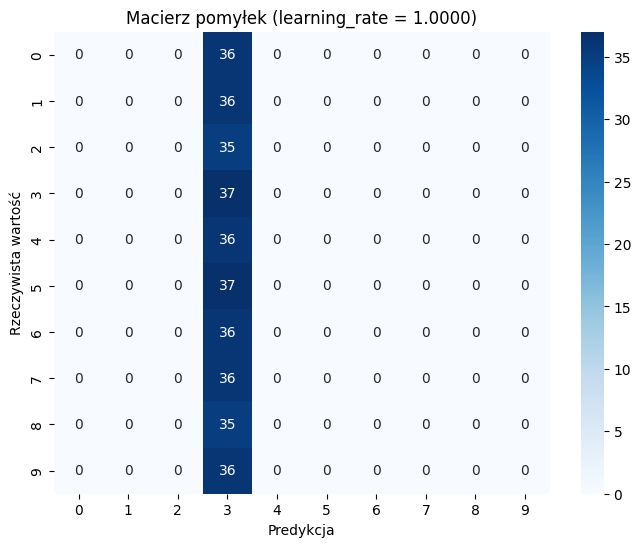

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


digits = load_digits()
X, y = digits.data, digits.target

# Podział zbioru na treningowy / testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standaryzacja danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Testowane wartości współczynnika uczenia
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]

# Przechowywanie wyników
results = []

for lr in learning_rates:
    # Tworzenie i trenowanie modelu MLP z SGD
    mlp = MLPClassifier(
        hidden_layer_sizes=(100, 100),
        activation='relu',
        solver='sgd',
        learning_rate_init=lr,  # Współczynnik uczenia
        max_iter=1000,
        random_state=42
    )

    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results.append((lr, acc))

    print(f"Learning Rate: {lr:.4f} -> Accuracy: {acc:.4f}")


# -------------------------------
import pandas as pd
df_results = pd.DataFrame(results, columns=['Learning Rate', 'Accuracy'])

# Wykres zależności skuteczności od `learning_rate`
plt.figure(figsize=(8,5))
sns.lineplot(x='Learning Rate', y='Accuracy', marker='o', data=df_results)
plt.xscale('log')
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Accuracy")
plt.title("Wpływ współczynnika uczenia na skuteczność klasyfikacji")
plt.show()



# Najciekawsze przypadki
best_lr = max(results, key=lambda x: x[1])[0]  # Najlepsza wartość learning_rate
worst_lr = min(results, key=lambda x: x[1])[0]  # Najgorsza wartość learning_rate

for lr in [best_lr, worst_lr]:
    # Ponowne trenowanie dla wybranej wartości
    mlp = MLPClassifier(
        hidden_layer_sizes=(100, 100),
        activation='relu',
        solver='sgd',
        learning_rate_init=lr,
        max_iter=1000,
        random_state=42
    )

    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)

    # Macierz pomyłek
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Wyświetlenie wyników
    print(f"\n== Wyniki dla Learning Rate = {lr:.4f} ==")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Raport klasyfikacji:")
    print(classification_report(y_test, y_pred))

    # Wizualizacja macierzy pomyłek
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=digits.target_names, yticklabels=digits.target_names)
    plt.xlabel("Predykcja")
    plt.ylabel("Rzeczywista wartość")
    plt.title(f"Macierz pomyłek (learning_rate = {lr:.4f})")
    plt.show()





1. Dla learning_rate = 0.1 (najlepszy wynik)
> Model osiągnął 97.50% dokładności, co pokazuje dobrą zdolność do generalizacji. Macierz pomyłek (Obraz 1) wykazuje niewiele błędnych klasyfikacji, co potwierdzają również wysokie wartości precision, recall i f1-score. Jedynie klasa 8 miała kilka błędnych predykcji.

2. Dla learning_rate = 1.0 (najgorszy wynik)
> Model całkowicie się rozregulował – przewiduje głównie jedną klasę (3), co widać w macierzy pomyłek (Obraz 2). Dokładność spadła do 10.28%, a metryki jakościowe dla większości klas wynoszą 0, co oznacza całkowitą nieużyteczność modelu.

>Zbyt niski learning_rate (np. 0.0001) – model konwerguje bardzo wolno, co może prowadzić do niedouczenia.
>
>Optymalny learning_rate (0.1) – zapewnia dobrą równowagę między szybkością uczenia a dokładnością.
>
>Zbyt wysoki learning_rate (1.0) – model nie uczy się poprawnie, oscyluje wokół jednej klasy i nie znajduje optymalnych wag.

---



> *Eksperyment pokazał, że wybór funkcji aktywacji ma istotny wpływ na skuteczność modelu – logistic i tanh wypadły lepiej niż ReLU, co sugeruje ich większą przydatność w tym zadaniu. Spośród testowanych algorytmów optymalizacji najlepsze wyniki osiągnął Adam, podczas gdy SGD wymagał znacznie większej liczby epok, aby osiągnąć stabilną skuteczność. Zwiększanie liczby neuronów i warstw nie zawsze prowadziło do poprawy wyników, co oznacza, że bardziej złożone modele niekoniecznie są lepsze. Istotnym czynnikiem okazał się współczynnik uczenia – zbyt niski (np. 0.0001) powodował wolną konwergencję i ryzyko niedouczenia, natomiast zbyt wysoki (np. 1.0) sprawiał, że model nie uczył się poprawnie, oscylując wokół jednej klasy. Najlepszą równowagę między szybkością uczenia a skutecznością zapewniało ustawienie learning_rate na poziomie 0.1.*


---



---



#4.1
**Proszę pobrać zbiór yeast z UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Yeast). Proszę we własnym zakresie dokonać wstępnej analizy i przygotowania tego zbioru. Warto zauważyć, że liczności różnych klas wewnątrz zbioru są bardzo nierówne.**


Informacje o zbiorze:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mcg     1484 non-null   float64
 1   gvh     1484 non-null   float64
 2   alm     1484 non-null   float64
 3   mit     1484 non-null   float64
 4   erl     1484 non-null   float64
 5   pox     1484 non-null   float64
 6   vac     1484 non-null   float64
 7   nuc     1484 non-null   float64
 8   Class   1484 non-null   object 
dtypes: float64(8), object(1)
memory usage: 104.5+ KB
None

Liczność poszczególnych klas:
Class
CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: count, dtype: int64


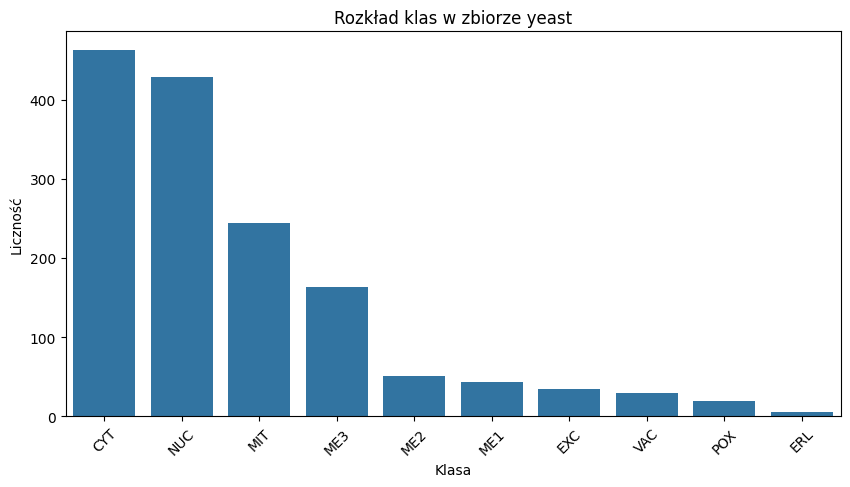


Zakodowane klasy:
{'CYT': np.int64(0), 'ERL': np.int64(1), 'EXC': np.int64(2), 'ME1': np.int64(3), 'ME2': np.int64(4), 'ME3': np.int64(5), 'MIT': np.int64(6), 'NUC': np.int64(7), 'POX': np.int64(8), 'VAC': np.int64(9)}

Kształt zbiorów po podziale:
X_train: (1187, 8), X_test: (297, 8)
y_train: (1187,), y_test: (297,)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

file_path = "/content/drive/My Drive/Colab Notebooks/MIO/lab03_yeast.data"

# Kolumny zbioru
columns = ["Sequence Name", "mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc", "Class"]

# spacja => sep="\s+")
yeast_data = pd.read_csv(file_path, sep="\s+", names=columns)

# Usunięcie pierwszej kolumny "Sequence Name", bo nie jest cechą
yeast_data.drop(columns=["Sequence Name"], inplace=True)


print("\nInformacje o zbiorze:")
print(yeast_data.info())

print("\nLiczność poszczególnych klas:")
print(yeast_data["Class"].value_counts())


plt.figure(figsize=(10,5))
sns.barplot(x=yeast_data["Class"].value_counts().index,
            y=yeast_data["Class"].value_counts().values,
            )

plt.xlabel("Klasa")
plt.ylabel("Liczność")
plt.title("Rozkład klas w zbiorze yeast")
plt.xticks(rotation=45)
plt.show()


# Konwersja etykiet klas do wartości liczbowych
label_encoder = LabelEncoder()
yeast_data["Class"] = label_encoder.fit_transform(yeast_data["Class"])

print("\nZakodowane klasy:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


# Wydzielenie cech (X) i etykiet (y)
X = yeast_data.drop(columns=["Class"])
y = yeast_data["Class"]

# Standaryzacja danych
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Podział na zbiór treningowy / testowy
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)

print("\nKształt zbiorów po podziale:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")






>Eksperyment pokazał, że zbiór yeast składa się z 1484 próbek i 8 cech numerycznych. Klasy są bardzo nierównomiernie reprezentowane – dominują CYT (463) i NUC (429), podczas gdy ERL (5) i POX (20) są nieliczne, co może powodować problemy z klasyfikacją. Dane nie zawierają brakujących wartości, a etykiety klas zostały zakodowane numerycznie.
>
>Przed treningiem modelu przeprowadzono standaryzację cech oraz podział zbioru na część treningową (1187 próbek) i testową (297 próbek) z zachowaniem proporcji klas.


---



#4.2
**Proszę spróbować osiągnąć jak najlepsze wyniki i narysować dla nich macierz pomyłek (dla zbioru uczącego i testującego) oraz wyliczyć wszystkie poznane do tej pory metryki.**

**Czy dokładność na poziomie 0.5 dla takiego zbioru jest dobra? Mogą państwo zbadać też czas wykonywania funkcji fit dla różnych konfiguracji sieci.**

Testowanie konfiguracji: (50,)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Testowanie konfiguracji: (100,)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Testowanie konfiguracji: (50, 50)
Testowanie konfiguracji: (100, 50)
Testowanie konfiguracji: (100, 100)
Testowanie konfiguracji: (200, 100, 50)

Skuteczność dla różnych konfiguracji sieci:
Konfiguracja (50,): Skuteczność 0.5892, Czas treningu: 9.63 sek
Konfiguracja (100,): Skuteczność 0.5657, Czas treningu: 10.71 sek
Konfiguracja (50, 50): Skuteczność 0.5758, Czas treningu: 7.73 sek
Konfiguracja (100, 50): Skuteczność 0.5320, Czas treningu: 18.10 sek
Konfiguracja (100, 100): Skuteczność 0.5657, Czas treningu: 27.90 sek
Konfiguracja (200, 100, 50): Skuteczność 0.5354, Czas treningu: 17.69 sek

Najlepsza konfiguracja: (50,) z dokładnością 0.5892


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Metryki dla zbioru testowego:
              precision    recall  f1-score   support

         CYT       0.55      0.65      0.59        93
         ERL       1.00      1.00      1.00         1
         EXC       0.67      0.57      0.62         7
         ME1       0.80      0.89      0.84         9
         ME2       0.33      0.30      0.32        10
         ME3       0.76      0.69      0.72        32
         MIT       0.60      0.57      0.58        49
         NUC       0.57      0.56      0.56        86
         POX       1.00      0.25      0.40         4
         VAC       1.00      0.17      0.29         6

    accuracy                           0.59       297
   macro avg       0.73      0.56      0.59       297
weighted avg       0.61      0.59      0.59       297



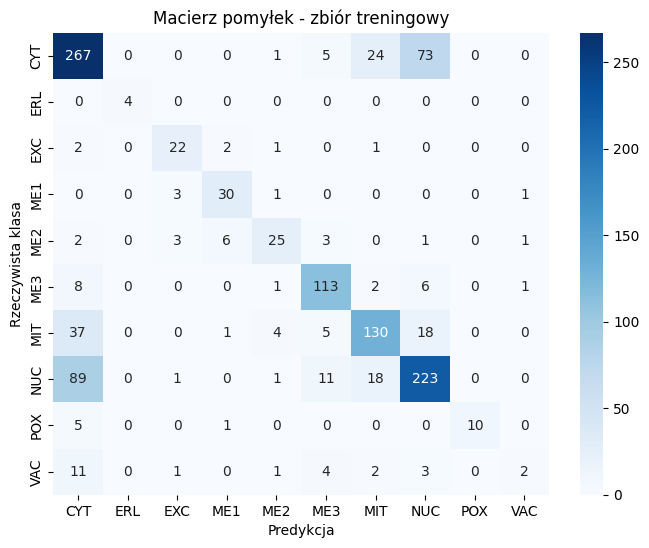

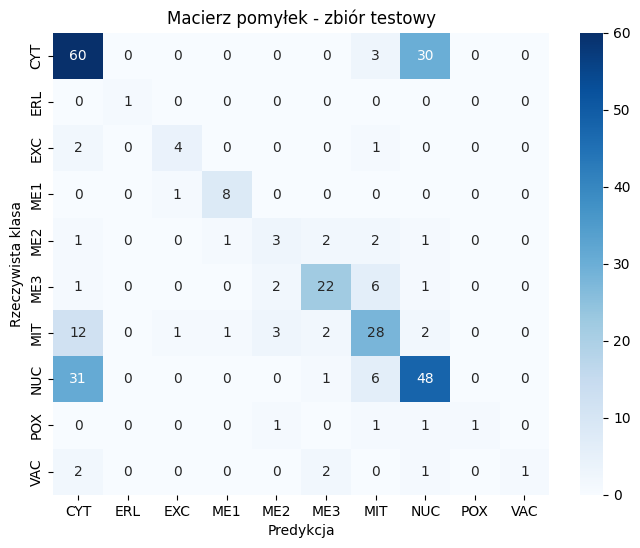

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Lista architektur do testowania
hidden_layer_configs = [
    (50,), (100,), (50,50), (100,50), (100,100), (200,100,50)
]

# Przechowywanie wyników
results = {}

for config in hidden_layer_configs:
    print(f"Testowanie konfiguracji: {config}")

    # Start pomiaru czasu
    start_time = time.time()

    # Tworzenie modelu MLP
    mlp = MLPClassifier(hidden_layer_sizes=config, activation='relu', solver='adam', max_iter=2000, alpha=0.0001, random_state=42)

    # Trenowanie modelu
    mlp.fit(X_train, y_train)

    # Predykcja na zbiorze testowym
    y_pred = mlp.predict(X_test)

    # Ocena skuteczności
    test_accuracy = accuracy_score(y_test, y_pred)

    # Czas treningu
    train_time = time.time() - start_time

    # Zapis wyników
    results[config] = (test_accuracy, train_time)

# Wyświetlenie wyników
print("\nSkuteczność dla różnych konfiguracji sieci:")
for config, (accuracy, train_time) in results.items():
    print(f"Konfiguracja {config}: Skuteczność {accuracy:.4f}, Czas treningu: {train_time:.2f} sek")




# Znalezienie najlepszej konfiguracji
best_config = max(results, key=lambda x: results[x][0])
print(f"\nNajlepsza konfiguracja: {best_config} z dokładnością {results[best_config][0]:.4f}")

# Trenowanie najlepszego modelu
best_model = MLPClassifier(hidden_layer_sizes=best_config, activation='relu', solver='adam', max_iter=1000, alpha=0.0001, random_state=42)
best_model.fit(X_train, y_train)

# Predykcja
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)




# Raport metryk dla zbioru testowego
print("\nMetryki dla zbioru testowego:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Macierz pomyłek dla zbioru treningowego
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Funckja do rysowania macierzy pomyłek
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predykcja")
    plt.ylabel("Rzeczywista klasa")
    plt.title(title)
    plt.show()

# Rysowanie macierzy pomyłek
plot_confusion_matrix(conf_matrix_train, "Macierz pomyłek - zbiór treningowy")
plot_confusion_matrix(conf_matrix_test, "Macierz pomyłek - zbiór testowy")


>W przeprowadzonym eksperymencie dokonano analizy klasyfikacji danych z zestawu yeast przy użyciu wielowarstwowej sieci neuronowej (MLPClassifier). Testowano różne konfiguracje sieci neuronowej, a najlepszy wynik osiągnięto dla architektury jednowarstwowej z 50 neuronami w warstwie ukrytej, uzyskując dokładność 58,92% na zbiorze testowym.

>Analiza macierzy pomyłek wskazuje na kilka istotnych problemów:
>
>- Silna niezbalansowaność klas – dominujące klasy, takie jak CYT i NUC, mają znacznie więcej przykładów niż pozostałe, co prowadzi do gorszej skuteczności dla rzadszych klas (tj. ERL, POX, VAC).
>- Częste błędne klasyfikacje między klasami o podobnych cechach – np. pomyłki między MIT a NUC oraz między ME3 a MIT.
>- Niska skuteczność dla mniej licznych klas – model ma trudności w poprawnej klasyfikacji klas o bardzo małej liczbie próbek (np. ERL, POX).
>
>Pomimo stosunkowo niskiej dokładności, wynik 0,59 można uznać za umiarkowanie akceptowalny, biorąc pod uwagę stopień skomplikowania problemu i niezbalansowaną naturę zbioru. Lepszą miarą jakości klasyfikacji są jednak metryki takie jak precision, recall i F1-score, które pokazują, że model lepiej radzi sobie z niektórymi klasami, ale znacznie gorzej z innymi.



---



---

